# UNET IMPLEMENTATION USING PYTORCH

#### Importing reqired libraries

In [8]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import torchvision 
import torchvision.transforms as transforms
import numpy as np

### The UNET architecture:

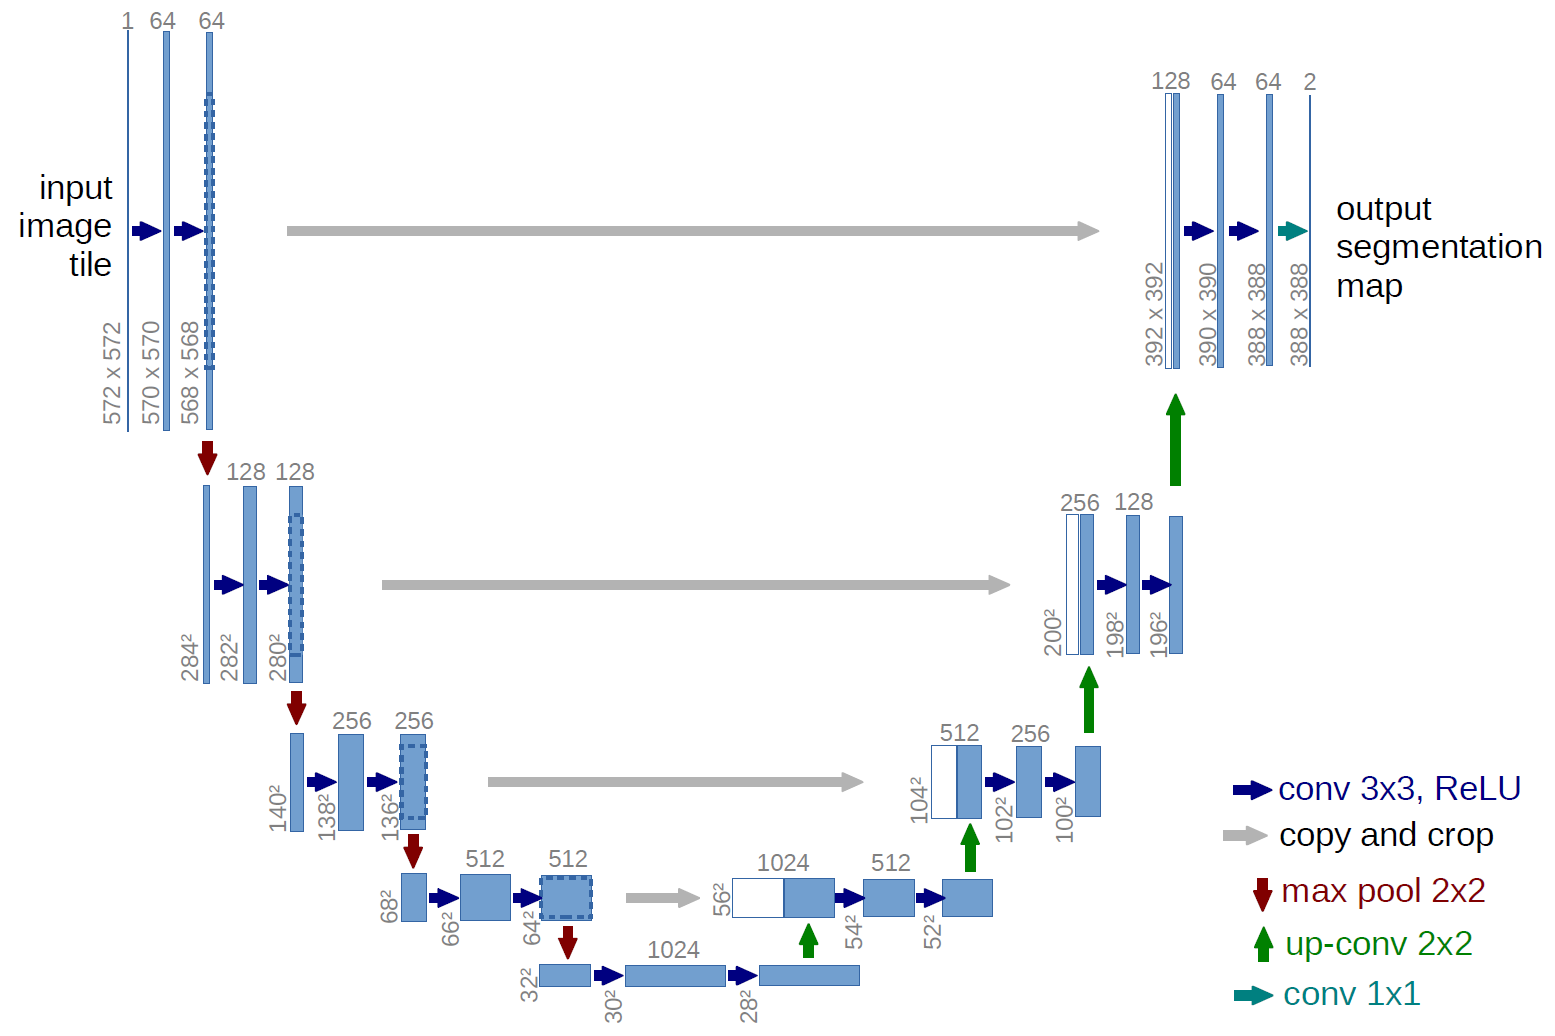

## It consists of: 
### Contracting path (ENCODER)
(Which is like a typical Convolutioal Neural Network architecture)
and 
### Expanding path (DECODER)

> **in_c and out_c** are the input and output channels parameters 

> **inplace=True** modifies the input directly

> **torch.nn.Modules** is the base class for nn modules


The U-net downscaling path architecture consists of the repeated application of-
* (3x3) convolutional layers
* ReLU layer 

Followed by a Max pooling layer (with stride=2)

The U-net upscaling path architecture consists of the repeated application of-
* (3x3) convolutional layers
* ReLU layer 

Followed by tranposed convolutional layer

#### Double convolutional layer:

In [2]:
def conv_repeat(in_c,out_c): 
    cnn=nn.Sequential(
        
        nn.Conv2d(in_c,out_c,kernel_size=3),
        nn.ReLU(inplace=True),
        
        nn.Conv2d(out_c,out_c,kernel_size=3),
        nn.ReLU(inplace=True)
    )
    return cnn

> xone is the output of down_conv_1

We define another function crop() to crop the images that need to be copied while upsampling

In [3]:
def crop(tensor,target_tensor):
    target_size=target_tensor.size()[2]
    tensor_size=tensor.size()[2]
    
    delta=tensor_size-target_size
    delta=delta//2
    
    return tensor[:,:,delta:tensor_size-delta,delta:tensor_size-delta]
    # tensor[batch_size, channel, height, width]

#### Unet architecture:

In [110]:
class UNET(nn.Module): 
    
    def __init__(self):
        super(UNET,self).__init__()
        
        self.max_pool_2x2= nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.down_conv_1=conv_repeat(1,64)
        self.down_conv_2=conv_repeat(64,128)
        self.down_conv_3=conv_repeat(128,256)
        self.down_conv_4=conv_repeat(256,512)
        self.down_conv_5=conv_repeat(512,1024)
        
        
        
        self.up_transpose_1=nn.ConvTranspose2d(in_channels=1024,
                                         out_channels=512,
                                         kernel_size=2,
                                         stride=2)
        
        self.up_conv_1=conv_repeat(1024,512)
        
        
        self.up_transpose_2=nn.ConvTranspose2d(in_channels=512,
                                         out_channels=256,
                                         kernel_size=2,
                                         stride=2)
        
        self.up_conv_2=conv_repeat(512,256)
        
        
        self.up_transpose_3=nn.ConvTranspose2d(in_channels=256,
                                         out_channels=128,
                                         kernel_size=2,
                                         stride=2)
        
        self.up_conv_3=conv_repeat(256,128)
        
        
        self.up_transpose_4=nn.ConvTranspose2d(in_channels=128,
                                         out_channels=64,
                                         kernel_size=2,
                                         stride=2)
        
        self.up_conv_4=conv_repeat(128,64)
        
        
        
        self.output= nn.Conv2d(in_channels=64,
                              out_channels=10,
                              kernel_size=1)
        
        
    
    def forward(self,img):
        
        #Contracting path
        xone=self.down_conv_1(img)
        
#         print(xone.size())
        xtwo=self.max_pool_2x2(xone)
        
        xthree=self.down_conv_2(xtwo)
        xfour=self.max_pool_2x2(xthree)
        
        xfive=self.down_conv_3(xfour)
        xsix=self.max_pool_2x2(xfive)
        
        xseven=self.down_conv_4(xsix)
        xeight=self.max_pool_2x2(xseven)
        
        xnine=self.down_conv_5(xeight)
        
#         print(xnine.size())
        
        #Expanding path
        x=self.up_transpose_1(xnine)
        xcrop=crop(xseven,x)
        x=self.up_conv_1(torch.cat([x,xcrop],1))
        
        x=self.up_transpose_2(x)
        xcrop=crop(xfive,x)
        x=self.up_conv_2(torch.cat([x,xcrop],1))
        
        x=self.up_transpose_3(x)
        xcrop=crop(xthree,x)
        x=self.up_conv_3(torch.cat([x,xcrop],1))
        
        x=self.up_transpose_4(x)
        xcrop=crop(xone,x)
        x=self.up_conv_4(torch.cat([x,xcrop],1))
        
        x=self.output(x)
        print(x.size())
        
        return x
        
#         print("Uncropped ",xseven.size())
#         print("Cropped: ",xcrop.size())

In [111]:
if __name__=="__main__":
    img=torch.rand((1,1,572,572)) 
    #(batch_size,channel,height,width)
    model=UNET()
    print(model(img))

torch.Size([1, 10, 388, 388])
tensor([[[[ 0.1058,  0.1071,  0.1024,  ...,  0.1149,  0.1112,  0.1119],
          [ 0.1130,  0.1052,  0.1081,  ...,  0.1107,  0.1008,  0.1111],
          [ 0.1125,  0.1077,  0.1113,  ...,  0.1107,  0.1032,  0.1087],
          ...,
          [ 0.1047,  0.1046,  0.1082,  ...,  0.1049,  0.1076,  0.1101],
          [ 0.1029,  0.1110,  0.1047,  ...,  0.1066,  0.1092,  0.1043],
          [ 0.1103,  0.1025,  0.1034,  ...,  0.1113,  0.1122,  0.1085]],

         [[-0.0843, -0.0851, -0.0833,  ..., -0.0826, -0.0812, -0.0799],
          [-0.0832, -0.0808, -0.0815,  ..., -0.0881, -0.0830, -0.0887],
          [-0.0842, -0.0847, -0.0919,  ..., -0.0853, -0.0853, -0.0821],
          ...,
          [-0.0848, -0.0837, -0.0755,  ..., -0.0792, -0.0847, -0.0892],
          [-0.0846, -0.0827, -0.0804,  ..., -0.0849, -0.0873, -0.0794],
          [-0.0857, -0.0878, -0.0771,  ..., -0.0817, -0.0829, -0.0887]],

         [[-0.0500, -0.0483, -0.0488,  ..., -0.0409, -0.0487, -0.0456],


In [112]:
a=UNET()
a

UNET(
  (max_pool_2x2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_conv_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down_conv_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down_conv_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down_conv_4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down_conv_5): Sequential(
    (0): Conv2d(512, 1024, kernel_

In [113]:
train_imgs=torchvision.datasets.FashionMNIST(
root='./data/FashionMNIST'
    ,train=True
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ])
)
train_load=torch.utils.data.DataLoader(
train_imgs,batch_size=10
)

In [114]:
torch.set_printoptions(linewidth=120)

In [115]:
len(train_imgs)

60000

In [116]:
train_imgs.train_labels

/home/lakshmi11/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


tensor([9, 0, 0,  ..., 3, 0, 5])

In [117]:
train_imgs.train_labels

tensor([9, 0, 0,  ..., 3, 0, 5])

In [118]:
train_imgs.train_labels.bincount()

tensor([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

In [119]:
sample=next(iter(train_imgs))

In [120]:
len(sample)

2

In [121]:
type(sample)

tuple

In [122]:
image=sample[0]
label=sample[1]

#or image,label=sample

In [123]:
image.shape

torch.Size([1, 28, 28])

label:  9


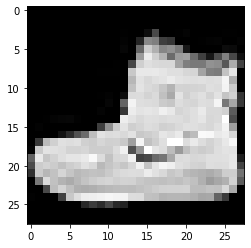

In [124]:
plt.imshow(image.squeeze(),cmap="gray")
print('label: ',label)

In [125]:
batch=next(iter(train_load))

In [126]:
len(batch)

2

In [127]:
type(batch)

list

In [128]:
images,labels=batch

In [129]:
images.shape

torch.Size([10, 1, 28, 28])

In [130]:
labels.shape

torch.Size([10])

labels:  tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5])


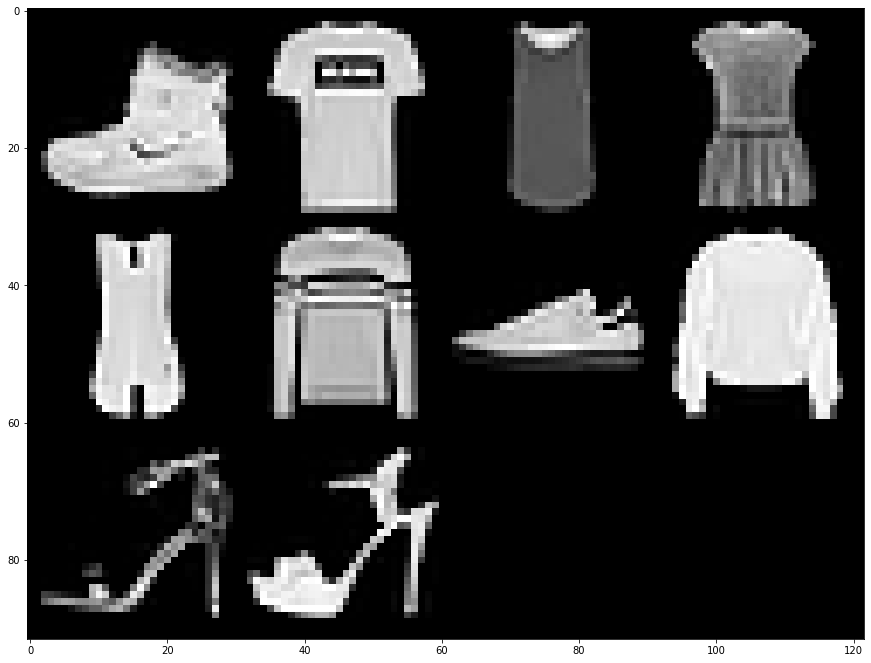

In [131]:
grid=torchvision.utils.make_grid(images,nrow=4)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid,(1,2,0)))
print('labels: ',labels)

In [132]:
train_load=torch.utils.data.DataLoader(train_imgs,batch_size=100)

In [133]:
batch=next(iter(train_load))
images,labels=batch

labels:  tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9, 1, 0, 6, 4, 3, 1, 4, 8, 4, 3, 0, 2, 4, 4, 5, 3, 6, 6, 0, 8, 5,
        2, 1, 6, 6, 7, 9, 5, 9, 2, 7, 3, 0, 3, 3, 3, 7, 2, 2, 6, 6, 8, 3, 3, 5, 0, 5, 5, 0, 2, 0, 0, 4, 1, 3, 1, 6, 3,
        1, 4, 4, 6, 1, 9, 1, 3, 5, 7, 9, 7, 1, 7, 9, 9, 9, 3, 2, 9, 3, 6, 4, 1, 1, 8])


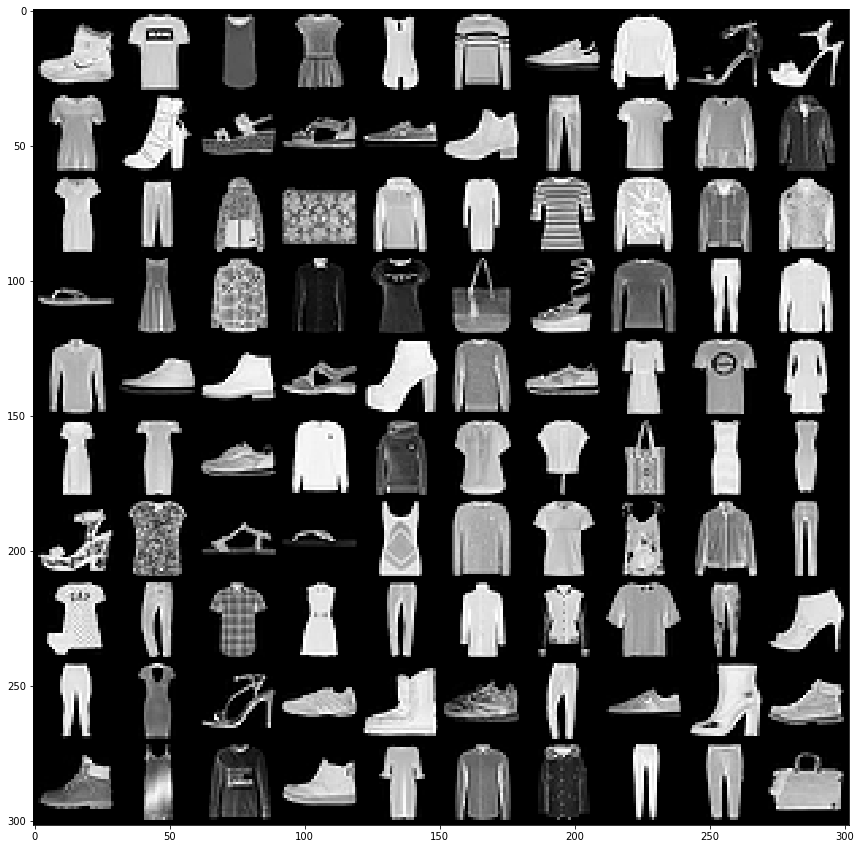

In [134]:
grid=torchvision.utils.make_grid(images,nrow=10)

plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid,(1,2,0)))

print('labels: ',labels)

In [135]:
model=a.__init__()